In [1]:
from brian2 import *
import brian2.numpy_ as np
import h5py
import time
import os
import brian2genn

prefs["devices.genn.path"] = "/opt/pyc/genn-3.1.1"
prefs["devices.genn.cuda_path"] = "/usr/local/cuda"
set_device("genn")


MNIST_TRAIN_HDF5_FILE = '../nest/HDF5_MNIST_TRAIN.h5'
MNIST_TEST_HDF5_FILE = '../nest/HDF5_MNIST_TEST.h5'

MNIST_TRAIN_SPIKE_FILE = "First100ImgSpikeTrainData.h5"
STDP_WEIGHTS_FILE = "stdp_weights_100pics.h5"

IMG_SIZE = 784
total = 1000 * second
pattern_length = 250*ms
repeat_every = pattern_length * 4
n_repetitions = int(total/repeat_every)

train_data_total_time = 5000 * second
sim_time = 50 * 10 * second


def load_train_data(hdf5_path):
    f = h5py.File(hdf5_path)
    indices = f["indices"][:]
    times = f["times"][:]
    f.close()
    return indices, times


indices, times = load_train_data(MNIST_TRAIN_SPIKE_FILE)
# attention, the generated times' unit is ms
times = times * ms

N = 784
tau_m = 5*ms
V_r = -70*mV
V_th = -55*mV
tau_e = 3*ms
tau_i = 10*ms
lambda_e = (tau_e / tau_m) ** (tau_m / (tau_e - tau_m))
lambda_i = - (tau_i / tau_m) ** (tau_m / (tau_i - tau_m))
tau_trace = 20*ms
w_max = 2*mV
A_pot = 0.02*w_max
A_dep = -1.2*A_pot
eqs = '''
dV/dt = ((V_r - V) + I_e + I_i)/ tau_m : volt (unless refractory)
dI_e/dt = -I_e/tau_e : volt
dI_i/dt = -I_i/tau_i : volt
'''

print("# Inference Process")

neurons = NeuronGroup(100, model=eqs, method='euler',
                      threshold='V > V_th', reset='V = V_r',
                      refractory=5*ms, name="output")
neurons.V = V_r

N_e = N
sgg_spikes = SpikeGeneratorGroup(N, indices, times, period=train_data_total_time, name="sgg_layer")

e_synapses = Synapses(sgg_spikes, neurons,
                    '''w : volt''',
                       on_pre='''I_e += lambda_e*w''',
                       on_post='''w = w''')
e_synapses.connect()

if_exist = os.path.exists(STDP_WEIGHTS_FILE)
# if_exist = False
if(if_exist):
    print("Loading existed weights")
    f = h5py.File(STDP_WEIGHTS_FILE)
    weights = f["weights"][:]
    f.close()
    e_synapses.w = weights * volt
else:
    print("[E] No weights file found!")
    exit(1)

# mon = StateMonitor(neurons, 'V', record=0)

spike_mon = SpikeMonitor(neurons)

run(sim_time, report='stdout')

/opt/pyc/brian2env/lib/python3.5/site-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return np.issubdtype(np.bool, self.dtype)


# Inference Process
Loading existed weights
running brian code generation ...
building genn executable ...
executing genn binary on GPU ...


In [13]:
output_indices, output_times = spike_mon.it
output_times = output_times / second

 Progress : 0.002839 
 Progress : 0.145216 
 Progress : 0.309996 
 Progress : 0.397816 
 Progress : 0.462808 
 Progress : 0.535659 
 Progress : 0.713406 
 Progress : 0.765953 
 Progress : 0.903751 
 Progress : 0.909917 
Index: 0, Number: 5: 
9, 1, 19, 19, 1, 16, 24, 20, 16, 29, 24, 27, 24, 23, 25, 12, 3, 1, 27, 16, 22, 11, 12, 31, 28, 8, 15, 28, 11, 11, 27, 16, 24, 25, 28, 13, 28, 29, 13, 27, 2, 3, 15, 1, 2, 22, 31, 6, 18, 18, 13, 29, 10, 20, 12, 26, 5, 14, 13, 12, 15, 27, 11, 15, 29, 29, 30, 26, 27, 20, 28, 12, 4, 13, 26, 15, 14, 13, 28, 12, 24, 1, 24, 27, 12, 18, 29, 11, 29, 1, 27, 11, 27, 25, 15, 27, 22, 15, 5, 21, 
Index: 1, Number: 0: 
21, 0, 27, 27, 0, 16, 25, 23, 26, 24, 29, 28, 26, 26, 30, 25, 0, 0, 33, 22, 27, 19, 18, 31, 32, 22, 20, 31, 17, 20, 31, 30, 26, 27, 27, 19, 30, 33, 22, 30, 0, 0, 21, 1, 0, 30, 26, 0, 19, 23, 17, 28, 21, 21, 19, 29, 0, 19, 20, 23, 20, 32, 17, 21, 29, 32, 31, 31, 30, 24, 29, 21, 17, 20, 27, 20, 23, 0, 30, 21, 29, 0, 24, 30, 0, 24, 30, 0, 29, 0, 30, 21

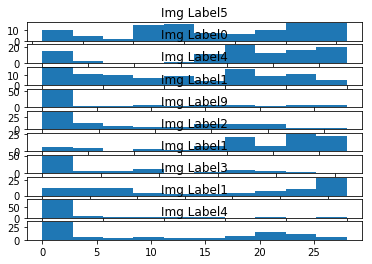

In [34]:
sum_spikes = np.zeros(shape=[10, 100], dtype=np.int32)
end_time = 0.25
current_index = 0
for i in range(len(output_times)):
    if(output_times[i] < end_time):
        if(output_times[i] >= end_time - 0.25):
            sum_spikes[current_index][output_indices[i]] += 1
    else:
        end_time += 50.0
        current_index += 1
        print(" Progress : %f " % (i / len(output_times)))

f = h5py.File(MNIST_TRAIN_HDF5_FILE)
train_label = f["label"][:]
f.close()

Index: 0, Number: 5: 
9, 1, 19, 19, 1, 16, 24, 20, 16, 29, 24, 27, 24, 23, 25, 12, 3, 1, 27, 16, 22, 11, 12, 31, 28, 8, 15, 28, 11, 11, 27, 16, 24, 25, 28, 13, 28, 29, 13, 27, 2, 3, 15, 1, 2, 22, 31, 6, 18, 18, 13, 29, 10, 20, 12, 26, 5, 14, 13, 12, 15, 27, 11, 15, 29, 29, 30, 26, 27, 20, 28, 12, 4, 13, 26, 15, 14, 13, 28, 12, 24, 1, 24, 27, 12, 18, 29, 11, 29, 1, 27, 11, 27, 25, 15, 27, 22, 15, 5, 21, 
Index: 1, Number: 0: 
21, 0, 27, 27, 0, 16, 25, 23, 26, 24, 29, 28, 26, 26, 30, 25, 0, 0, 33, 22, 27, 19, 18, 31, 32, 22, 20, 31, 17, 20, 31, 30, 26, 27, 27, 19, 30, 33, 22, 30, 0, 0, 21, 1, 0, 30, 26, 0, 19, 23, 17, 28, 21, 21, 19, 29, 0, 19, 20, 23, 20, 32, 17, 21, 29, 32, 31, 31, 30, 24, 29, 21, 17, 20, 27, 20, 23, 0, 30, 21, 29, 0, 24, 30, 0, 24, 30, 0, 29, 0, 30, 21, 27, 26, 19, 29, 25, 6, 4, 21, 
Index: 2, Number: 4: 
0, 4, 22, 20, 0, 9, 19, 20, 20, 11, 12, 19, 18, 22, 14, 1, 2, 2, 21, 9, 20, 9, 0, 20, 14, 21, 7, 18, 0, 12, 17, 15, 15, 4, 16, 6, 9, 19, 6, 17, 4, 0, 6, 0, 0, 19, 25

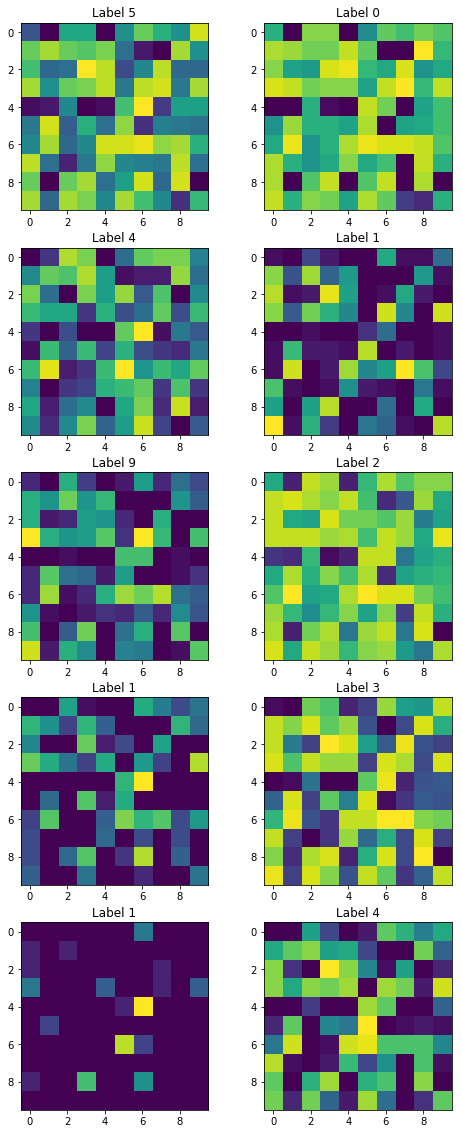

In [46]:
fig = plt.figure(figsize=(8,20))
for i in range(10):
    print("Index: %d, Number: %d" % (i,train_label[i]), end=": \n")
    for j in range(100):
        print(sum_spikes[i][j], end=", ")
    print()
    plt.subplot(5,2,i+1)
    plt.imshow(sum_spikes[i].reshape((10,10)))
    plt.title("Label {}".format(train_label[i]))
plt.show()

# fig, ax = plt.subplots()
# ax.vlines(np.arange(n_repetitions*10)*repeat_every/second, 0, 100, color='gray', alpha=0.5)
# ax.vlines(np.arange(n_repetitions*10)*repeat_every/second + pattern_length/second, 0, 100, color='gray', alpha=0.5)
# ax.plot(spike_mon.t/second, spike_mon.i, '|')
# ax.set(xlim=(0, 10), xlabel='time (s)')

# plt.show()

In [57]:
diffMatrix = np.zeros(shape=[10,10], dtype=np.int32)
for i in range(10):
    for j in range(10):
        diffMatrix[train_label[i]][train_label[j]] = np.sum(np.square(np.subtract(sum_spikes[i], sum_spikes[j])))

In [58]:
diffMatrix

array([[    0, 50808,  1529,  5507, 13297,  3602,     0,     0,     0,
        19147],
       [50808,     0, 55191, 40521, 20747, 36686,     0,     0,     0,
        12797],
       [ 1529, 55191,     0,  6210, 15904,  4071,     0,     0,     0,
        22160],
       [ 5507, 40521,  6210,     0,  5048,  2175,     0,     0,     0,
        10658],
       [13297, 20747, 15904,  5048,     0,  6231,     0,     0,     0,
         2934],
       [ 3602, 36686,  4071,  2175,  6231,     0,     0,     0,     0,
        10619],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [19147, 12797, 22160, 10658,  2934, 10619,     0,     0,     0,
            0]], dtype=int32)

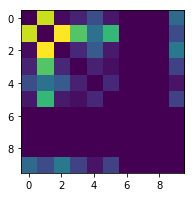

In [59]:
fig = plt.figure(figsize=(3,3))
plt.imshow(diffMatrix)
plt.show()